# Exploration of original cases

In this notebook we explore the characteristics of the original artificial cases datasets. We aim to answer the following questions:
- How many cases are there?
- How long are they?
- How many unique tokens are there?
- Are all of they structured in the same way?

We also have some metadata about the cases containing the MeSH terms in it. We will explore the distribution of these terms in the cases.

In [1]:
import pandas as pd
import os

import matplotlib.pyplot as plt

main_path = "data/3_toy_data"

# Data Exploration

## Amount of data

In [2]:
n_cc = len(os.listdir(main_path))
print("There are {} clinical cases".format(n_cc))

There are 10 clinical cases


In [3]:
def extract_txt(path, filename):
    total_path = os.path.join(path, filename)
    return filename, open(total_path, "r").read()

def files_to_df(path, extensions=["txt"]):
    files = [x for x in os.listdir(path) if x.split(".")[-1] in extensions]
    data = [extract_txt(path, f) for f in files]
    return pd.DataFrame(data, columns=["filename", "text"])

df = files_to_df(main_path)

In [4]:
df.head()

,filename,text
0,25679083.txt,### Discharge Summary \n\n**Patient Name:** J...
1,25878230.txt,### **Discharge Summary** \n\n**Patient Name:...
2,25654384.txt,### Discharge Summary \n\n**Patient Name:** [...
3,25531204.txt,### Discharge Summary \n\n**Patient Name:** [...
4,25803181.txt,### **Discharge Summary**\n\n**Patient Name:**...


In [5]:
df["text_orig"] = df["text"]
df["text"] = df["text_orig"].apply(lambda x: x.split("'text_to_transform': ")[-1][:-1].replace("'", ""))
df

,filename,text,text_orig
0,25679083.txt,### Discharge Summary \n\n**Patient Name:** J...,### Discharge Summary \n\n**Patient Name:** J...
1,25878230.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...
2,25654384.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...
3,25531204.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...
4,25803181.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...
5,26101300.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...
6,26156839.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...
7,25350173.txt,### Discharge Summary\n\n**Patient Name:** [Re...,### Discharge Summary\n\n**Patient Name:** [Re...
8,26336188.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...
9,26476073.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...


In [6]:
df["n_char"] = df["text"].str.len()
df["n_words"] = df["text"].str.split(r"\n|\s").str.len()
df.head()

,filename,text,text_orig,n_char,n_words
0,25679083.txt,### Discharge Summary \n\n**Patient Name:** J...,### Discharge Summary \n\n**Patient Name:** J...,3530,661
1,25878230.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,3413,694
2,25654384.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...,3406,645
3,25531204.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...,3886,723
4,25803181.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...,3312,599


Text(0.5, 1.0, 'Number of words in clinical cases')

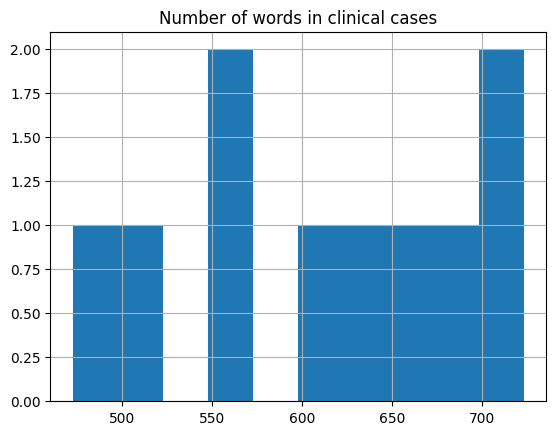

In [7]:
df["n_words"].hist(bins=10)
plt.title("Number of words in clinical cases")

In [8]:
df.describe()

,n_char,n_words
count,10.000000,10.000000
mean,3297.100000,614.000000
std,415.400596,86.660256
min,2553.000000,473.000000
25%,3004.250000,564.250000
50%,3359.000000,622.000000
75%,3500.750000,685.750000
max,3886.000000,723.000000


In [9]:
long_docs = df[df["n_words"] > 1500]

for i, row in long_docs.iterrows():
    print(row["filename"])
    print(row["text"])
    print("\n\n")

# Structure exploration

Some fields are created when the report is generated. Some interesting conclusions we can extract from below are:

- Not all the generated discharge summaries have the same amount of fields.
- The fields are usually structured as \*\*Section Name:\*\* followed by the content of the section.
- The content can be structured in different ways, some of them are structured in paragraphs, others in bullet points, etc.
- Unknown content is filled with placeholders like \[Datum van Opname\] instead of making it up
- There is some correlation between the amount of fields and the length of the case because it is possible that most of them have placeholders.

In [10]:
print(df.iloc[1]["text"])

### **Discharge Summary**  

**Patient Name:** [Redacted]  
**Medical Record Number:** [Redacted]  
**Date of Admission:** [Insert Date]  
**Date of Discharge:** [Insert Date]  
**Attending Physician:** [Insert Name]  

---

#### **Reason for Admission**  
Suspected infective endocarditis (IE) with fever, general fatigue, and positive blood cultures for *α-hemolytic Streptococcus*.  

---

#### **History of Present Illness**  
The patient, a 63-year-old man with no prior history of valvular disease or recent dental procedures, presented with a 2-month history of fever and painful, red, raised lesions on the palms. Blood cultures drawn at the referring hospital were positive for *α-hemolytic Streptococcus*. He was transferred for further evaluation and management of suspected IE.  

---

#### **Key Clinical Findings on Admission**  

- **Vital Signs:**  
  - Blood Pressure: 102/44 mmHg  
  - Pulse Rate: 83 beats/min  
  - Body Temperature: 38.9°C  

- **Physical Examination:**  
  - Ear

In [11]:
# Seems like all the fields are between ** so let's extract them
df["fields"] = df["text"].str.findall(r"\*\*([^\*]+):\*\*")
df["n_fields"] = df["fields"].str.len()
df

,filename,text,text_orig,n_char,n_words,fields,n_fields
0,25679083.txt,### Discharge Summary \n\n**Patient Name:** J...,### Discharge Summary \n\n**Patient Name:** J...,3530,661,"[Patient Name, Medical Record Number, Date of ...",21
1,25878230.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,3413,694,"[Patient Name, Medical Record Number, Date of ...",19
2,25654384.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...,3406,645,"[Patient Name, Medical Record Number, Date of ...",23
3,25531204.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...,3886,723,"[Patient Name, Medical Record Number, Date of ...",27
4,25803181.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...,3312,599,"[Patient Name, Medical Record Number, Date of ...",20
5,26101300.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,3848,710,"[Patient Name, Medical Record Number, Date of ...",20
6,26156839.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,2967,568,"[Patient Name, Medical Record Number, Date of ...",17
7,25350173.txt,### Discharge Summary\n\n**Patient Name:** [Re...,### Discharge Summary\n\n**Patient Name:** [Re...,2940,504,"[Patient Name, Medical Record Number, Date of ...",22
8,26336188.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,2553,473,"[Patient Name, Medical Record Number, Date of ...",11
9,26476073.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...,3116,563,"[Patient Name, Medical Record Number, Date of ...",13


Text(0.5, 1.0, 'Number of fields in clinical cases')

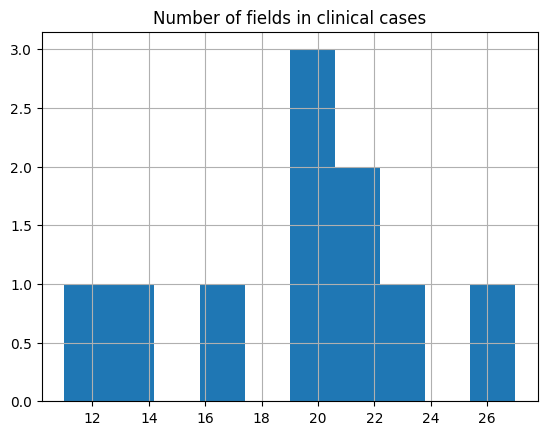

In [12]:
df["n_fields"].hist(bins=10)
plt.title("Number of fields in clinical cases")

In [13]:
df[df["n_fields"] >=50]

,filename,text,text_orig,n_char,n_words,fields,n_fields


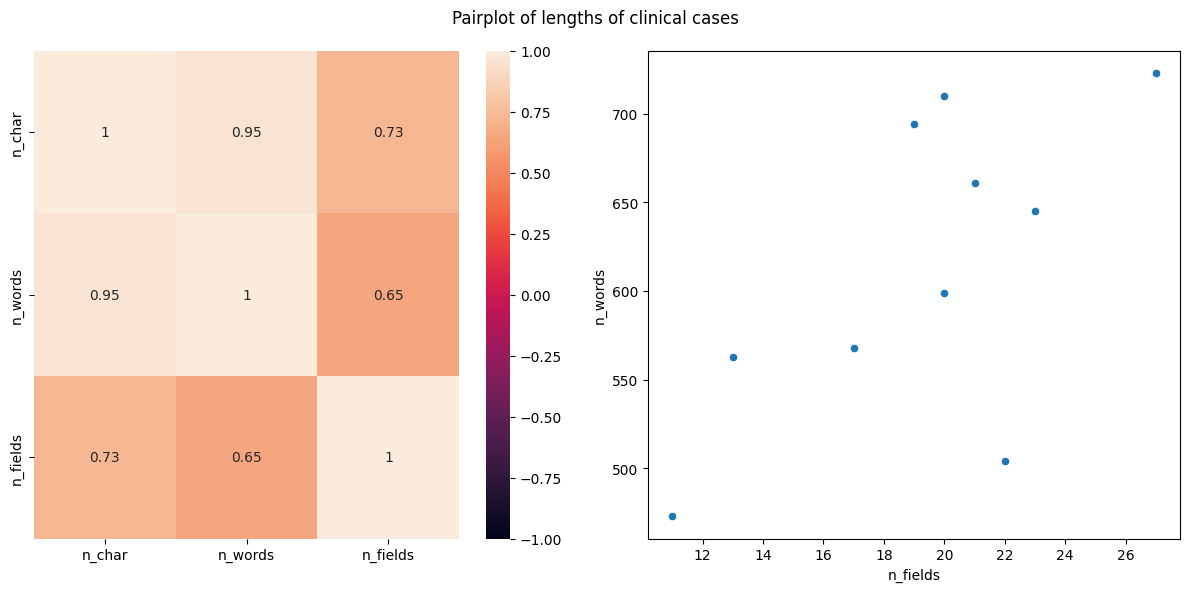

In [14]:
# Heatmap correlation matrix
import seaborn as sns
import numpy as np

cols = ["n_char", "n_words", "n_fields"]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(df[cols].corr(), annot=True, ax=ax[0], vmin=-1, vmax=1)
sns.scatterplot(x="n_fields", y="n_words", data=df, ax=ax[1])

plt.suptitle("Pairplot of lengths of clinical cases")
plt.tight_layout()

In [15]:
df["placeholders"] = df["text"].str.findall(r"\[(.+)\]")
df["n_placeholders"] = df["placeholders"].str.len()
df

,filename,text,text_orig,n_char,n_words,fields,n_fields,placeholders,n_placeholders
0,25679083.txt,### Discharge Summary \n\n**Patient Name:** J...,### Discharge Summary \n\n**Patient Name:** J...,3530,661,"[Patient Name, Medical Record Number, Date of ...",21,"[Last Name Redacted, Redacted, Insert Date, In...",7
1,25878230.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,3413,694,"[Patient Name, Medical Record Number, Date of ...",19,"[Redacted, Redacted, Insert Date, Insert Date,...",7
2,25654384.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...,3406,645,"[Patient Name, Medical Record Number, Date of ...",23,"[Redacted, Redacted, Insert Date, Insert Date,...",7
3,25531204.txt,### Discharge Summary \n\n**Patient Name:** [...,### Discharge Summary \n\n**Patient Name:** [...,3886,723,"[Patient Name, Medical Record Number, Date of ...",27,"[Redacted, Redacted, Insert Date, Insert Date,...",7
4,25803181.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...,3312,599,"[Patient Name, Medical Record Number, Date of ...",20,"[Redacted, Redacted, Insert Date, Insert Date,...",7
5,26101300.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,3848,710,"[Patient Name, Medical Record Number, Date of ...",20,"[Redacted, Redacted, Insert Date, Insert Date,...",7
6,26156839.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,2967,568,"[Patient Name, Medical Record Number, Date of ...",17,"[Redacted, Redacted, Insert Date, Insert Date,...",7
7,25350173.txt,### Discharge Summary\n\n**Patient Name:** [Re...,### Discharge Summary\n\n**Patient Name:** [Re...,2940,504,"[Patient Name, Medical Record Number, Date of ...",22,"[Redacted, Redacted, Insert Date, Insert Date,...",9
8,26336188.txt,### **Discharge Summary** \n\n**Patient Name:...,### **Discharge Summary** \n\n**Patient Name:...,2553,473,"[Patient Name, Medical Record Number, Date of ...",11,"[Redacted, Redacted, Insert Date, Insert Date,...",7
9,26476073.txt,### **Discharge Summary**\n\n**Patient Name:**...,### **Discharge Summary**\n\n**Patient Name:**...,3116,563,"[Patient Name, Medical Record Number, Date of ...",13,"[Redacted, Redacted, Insert Date, Insert Date,...",7


Text(0.5, 1.0, 'Number of placeholders in clinical cases')

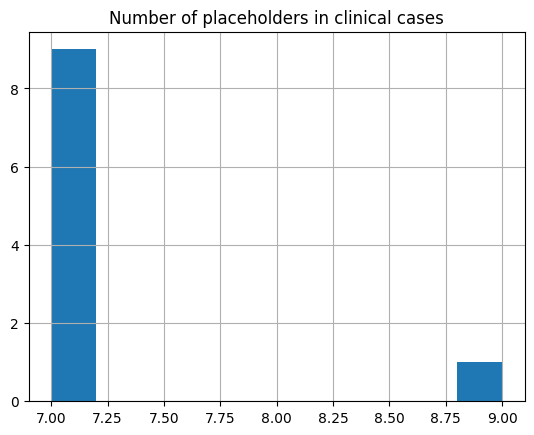

In [16]:
df["n_placeholders"].hist(bins=10)
plt.title("Number of placeholders in clinical cases")

In [17]:
df["cat_ph"] = df["n_placeholders"].apply(lambda x: "0" if x == 0 else "1-5" if x <= 5 else "6-10" if x <= 10 else ">10")

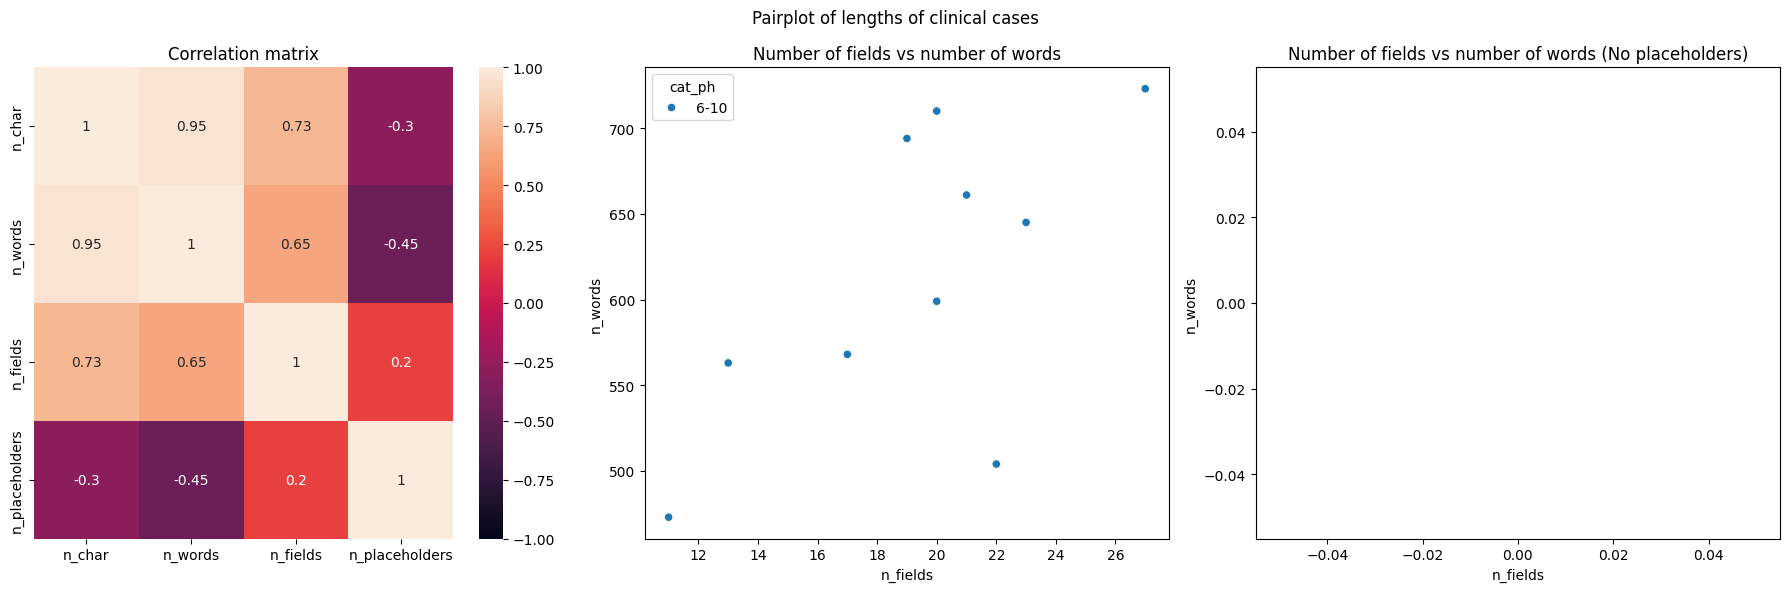

In [18]:
# Heatmap correlation matrix

cols = ["n_char", "n_words", "n_fields", "n_placeholders"]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(df[cols].corr(), annot=True, ax=ax[0], vmin=-1, vmax=1)
ax[0].set_title("Correlation matrix")

sns.scatterplot(x="n_fields", y="n_words", data=df, ax=ax[1], hue="cat_ph")
ax[1].set_title("Number of fields vs number of words")

sns.regplot(x="n_fields", y="n_words", data=df[df["n_placeholders"] == 0], ax=ax[2])
ax[2].set_title("Number of fields vs number of words (No placeholders)")

plt.suptitle("Pairplot of lengths of clinical cases")
plt.tight_layout()

In [19]:
df.describe()

,n_char,n_words,n_fields,n_placeholders
count,10.000000,10.000000,10.0000,10.000000
mean,3297.100000,614.000000,19.3000,7.200000
std,415.400596,86.660256,4.6916,0.632456
min,2553.000000,473.000000,11.0000,7.000000
25%,3004.250000,564.250000,17.5000,7.000000
50%,3359.000000,622.000000,20.0000,7.000000
75%,3500.750000,685.750000,21.7500,7.000000
max,3886.000000,723.000000,27.0000,9.000000
